## 강화학습 과제
- A66032 김우리
- 제출일 : 12월 12일
- 마감일 : 12월 12일



In [56]:
# 환경 임포트 한다. 
# 프로젝트 주제로 Atari Envtrionmentdml BreakOut을 선택하였다. 


## 프로그램의 동작을 설정한다. 
import gym
import collections
import random

# pytorch library is used for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

# hyperparameters
learning_rate = 0.00049
gamma = 0.99  
buffer_limit = 10000        # 버퍼 리밋의 의미 : 10000개 차면 옛날(old) 것부터 버려진다. 
batch_size = 30


In [57]:
class ReplayBuffer():
    def __init__(self): # 여기서 변수 등 초기화 한다. (transition을 담고 있는 테이블 등)
        self.buffer = collections.deque(maxlen=buffer_limit)    # 일반 디큐엔
    
    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n) # self.buffer 버퍼에서 n 개 뽑아서 준다. 
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        # done_mask_lst : next staterk terminate 인지 아닌지 찍음 

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)

        # 텐서로 바꿔서 리턴해준다. 

    def size(self):
        return len(self.buffer)

In [58]:
class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        # self.fc1 = nn.Linear(4, 128)
        # self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 2)
        self.fc1 = nn.Linear(6, 192)
        self.fc2 = nn.Linear(192, 192)
        self.fc3 = nn.Linear(192, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()  

In [60]:
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)

        # DQN <<<< DQN 일때 이거 수행
        #max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)

        # Double DQN <<<<<Double DQN 일 때 이거 수행
        # q_target q가 아니라 q_target에서 다음 state에서 액션의 최대값 추출
        argmax_Q = q(s_prime).max(1)[1].unsqueeze(1)
        max_q_prime = q_target(s_prime).gather(1, argmax_Q)
        
        # MSE Loss
        loss = F.mse_loss(q_a, target)
        # 손실함수는 mean Square Error 이걸로 뉴럴 네트워트를 학습시킬것이다. 

        # Smooth L1 Loss
        #loss = F.smooth_l1_loss(q_a, target)

        optimizer.zero_grad()
        loss.backward() # 오류역전파 backpropagation
        optimizer.step()

In [61]:
def main():
    # env = gym.make('Breakout-v4')
    env = gym.make("Acrobot-v1") # Acrobot 수행
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(6000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #입실론을 점점 줄인다
        s = env.reset()
        done = False
        
        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break

        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
            
            # type(n_epi)

    env.close()


if __name__ == '__main__':
    main()
    # print(type(n_epi))

    # sys.stdout = pd.to_csv('RL.csv')

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


n_episode :20, score : -441.1, n_buffer : 8830, eps : 7.9%
n_episode :40, score : -280.7, n_buffer : 10000, eps : 7.8%
n_episode :60, score : -319.9, n_buffer : 10000, eps : 7.7%
n_episode :80, score : -335.2, n_buffer : 10000, eps : 7.6%
n_episode :100, score : -386.9, n_buffer : 10000, eps : 7.5%
n_episode :120, score : -271.8, n_buffer : 10000, eps : 7.4%
n_episode :140, score : -288.9, n_buffer : 10000, eps : 7.3%
n_episode :160, score : -199.8, n_buffer : 10000, eps : 7.2%
n_episode :180, score : -288.4, n_buffer : 10000, eps : 7.1%
n_episode :200, score : -269.4, n_buffer : 10000, eps : 7.0%
n_episode :220, score : -333.6, n_buffer : 10000, eps : 6.9%
n_episode :240, score : -278.5, n_buffer : 10000, eps : 6.8%
n_episode :260, score : -225.0, n_buffer : 10000, eps : 6.7%
n_episode :280, score : -279.8, n_buffer : 10000, eps : 6.6%
n_episode :300, score : -231.2, n_buffer : 10000, eps : 6.5%
n_episode :320, score : -274.6, n_buffer : 10000, eps : 6.4%
n_episode :340, score : -262.

## 실행값을 로컬에 다운받은 후 csv파일로 임포트 하였다.

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
import pandas as pd

In [50]:
df = pd.read_csv('RL_PROJECT_2022_A66032.csv')

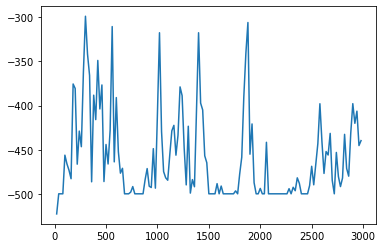

In [52]:
%matplotlib inline
plt.plot(df['n_episode'], df['score'])

In [62]:
df2 = pd.read_csv('RL_DQN_6000.csv')

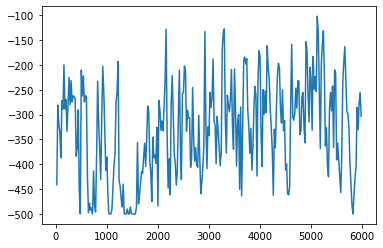

In [63]:
%matplotlib inline
plt.plot(df2['n_episode'], df2['score'])